In [9]:
%pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [11]:
trn_ds = MNIST('/content/', transform=img_transform, train=True, download=True)
val_ds = MNIST('/content/', transform=img_transform, train=False, download=True)

In [ ]:
batch_size = 256
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [12]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latend_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True),
            #nn.Linear(64, 12),  nn.ReLU(True),
            nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(
            #nn.Linear(latent_dim, 12), nn.ReLU(True),
            nn.Linear(latent_dim, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True),
            nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)
        return x

In [13]:
%pip install torch_summary
from torchsummary import summary
model = AutoEncoder(3).to(device)
summary(model, torch.zeros(2,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 3]                   195
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 64]                  256
|    └─ReLU: 2-7                         [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 128]                 8,320
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Linear: 2-10                      [-1, 784]                 101,136
|    └─Tanh: 2-11                        [-1, 784]                 

In [14]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

EPOCH: 1.000  val_loss: 0.196  trn_loss: 0.261  (25.42s - 101.67s remaining)
EPOCH: 2.000  val_loss: 0.170  trn_loss: 0.181  (44.18s - 66.26s remaining)
EPOCH: 3.000  val_loss: 0.159  trn_loss: 0.164  (62.18s - 41.45s remaining)
EPOCH: 4.000  val_loss: 0.154  trn_loss: 0.157  (83.44s - 20.86s remaining)
EPOCH: 5.000  val_loss: 0.151  trn_loss: 0.153  (103.65s - 0.00s remaining)


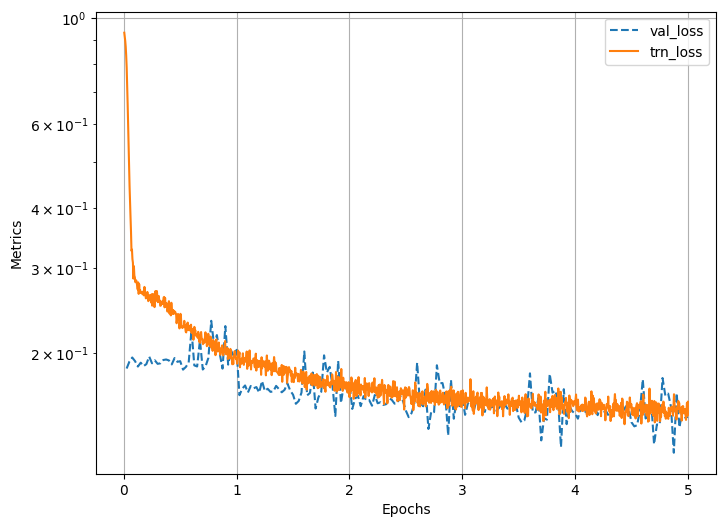

In [15]:
model = AutoEncoder(3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 5
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
    log.report_avgs(epoch+1)
log.plot(log=True)

In [17]:
import matplotlib.pyplot as plt

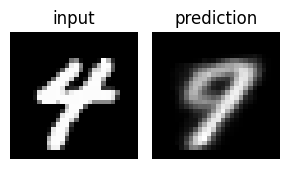

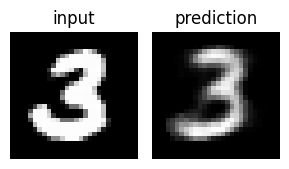

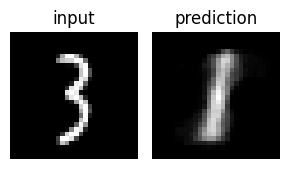

In [18]:
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1,2,figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show();

EPOCH: 1.000  val_loss: 0.142  trn_loss: 0.243  (22.61s - 90.45s remaining)
EPOCH: 2.000  val_loss: 0.106  trn_loss: 0.123  (40.82s - 61.23s remaining)
EPOCH: 3.000  val_loss: 0.090  trn_loss: 0.099  (58.65s - 39.10s remaining)
EPOCH: 4.000  val_loss: 0.080  trn_loss: 0.087  (79.01s - 19.75s remaining)
EPOCH: 5.000  val_loss: 0.073  trn_loss: 0.078  (96.81s - 0.00s remaining)


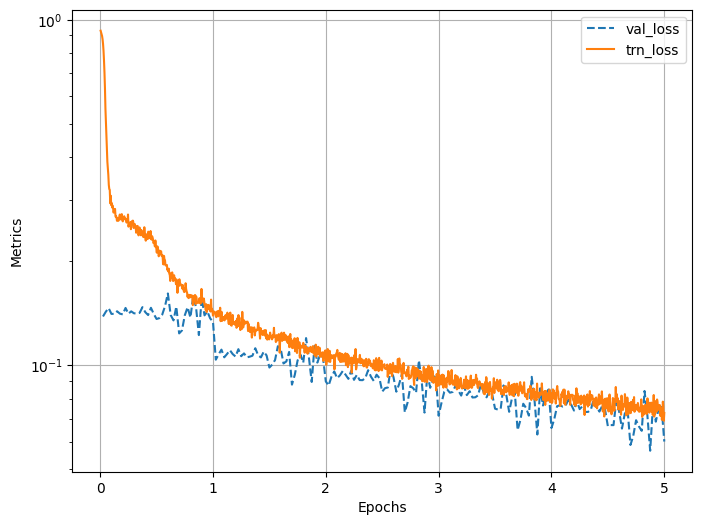

EPOCH: 1.000  val_loss: 0.208  trn_loss: 0.260  (18.46s - 73.83s remaining)
EPOCH: 2.000  val_loss: 0.188  trn_loss: 0.198  (36.08s - 54.11s remaining)
EPOCH: 3.000  val_loss: 0.177  trn_loss: 0.183  (54.83s - 36.55s remaining)
EPOCH: 4.000  val_loss: 0.172  trn_loss: 0.175  (72.54s - 18.14s remaining)
EPOCH: 5.000  val_loss: 0.171  trn_loss: 0.171  (91.52s - 0.00s remaining)


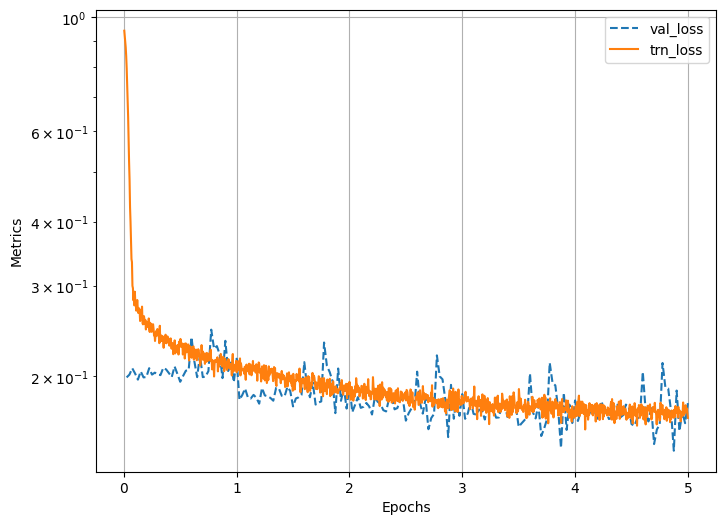

EPOCH: 1.000  val_loss: 0.190  trn_loss: 0.253  (17.70s - 70.81s remaining)
EPOCH: 2.000  val_loss: 0.164  trn_loss: 0.175  (36.65s - 54.97s remaining)
EPOCH: 3.000  val_loss: 0.155  trn_loss: 0.159  (54.72s - 36.48s remaining)
EPOCH: 4.000  val_loss: 0.149  trn_loss: 0.153  (73.27s - 18.32s remaining)
EPOCH: 5.000  val_loss: 0.147  trn_loss: 0.149  (91.99s - 0.00s remaining)


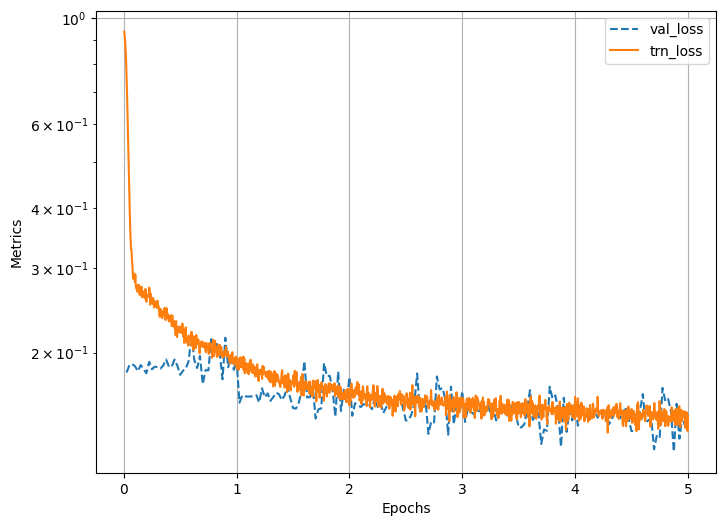

EPOCH: 1.000  val_loss: 0.167  trn_loss: 0.249  (18.29s - 73.16s remaining)
EPOCH: 2.000  val_loss: 0.141  trn_loss: 0.152  (36.93s - 55.39s remaining)
EPOCH: 3.000  val_loss: 0.129  trn_loss: 0.135  (54.99s - 36.66s remaining)
EPOCH: 4.000  val_loss: 0.123  trn_loss: 0.126  (73.66s - 18.41s remaining)
EPOCH: 5.000  val_loss: 0.119  trn_loss: 0.121  (91.85s - 0.00s remaining)


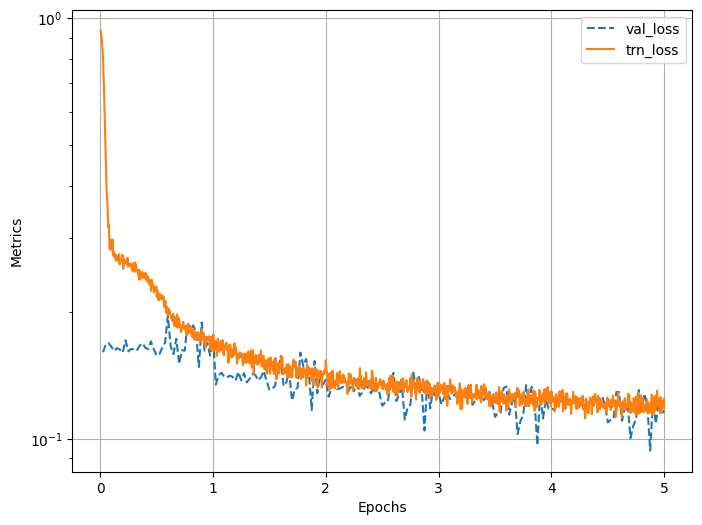

EPOCH: 1.000  val_loss: 0.157  trn_loss: 0.254  (19.00s - 75.99s remaining)
EPOCH: 2.000  val_loss: 0.111  trn_loss: 0.131  (37.42s - 56.14s remaining)
EPOCH: 3.000  val_loss: 0.097  trn_loss: 0.104  (56.50s - 37.67s remaining)
EPOCH: 4.000  val_loss: 0.091  trn_loss: 0.096  (74.89s - 18.72s remaining)
EPOCH: 5.000  val_loss: 0.087  trn_loss: 0.090  (93.79s - 0.00s remaining)


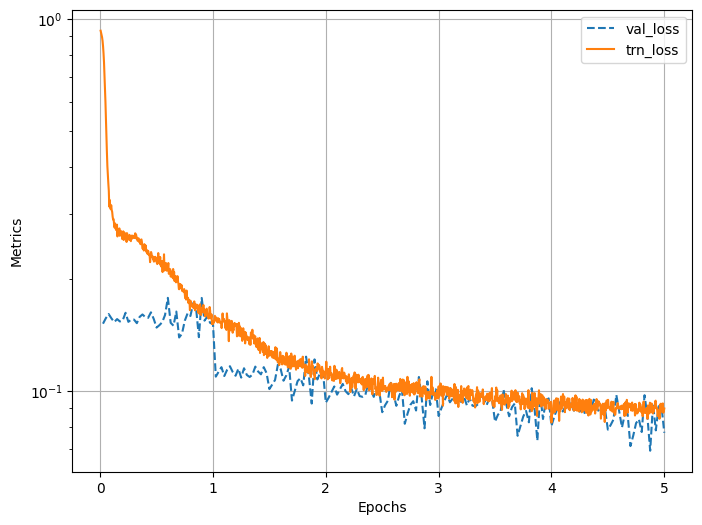

In [19]:
def train_aec(latent_dim):
    model = AutoEncoder(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

    num_epochs = 5
    log = Report(num_epochs)

    for epoch in range(num_epochs):
        N = len(trn_dl)
        for ix, (data, _) in enumerate(trn_dl):
            loss = train_batch(data, model, criterion, optimizer)
            log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

        N = len(val_dl)
        for ix, (data, _) in enumerate(val_dl):
            loss = validate_batch(data, model, criterion)
            log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
        log.report_avgs(epoch+1)
    log.plot(log=True)
    return model

aecs = [train_aec(dim) for dim in [50, 2, 3, 5, 10]]

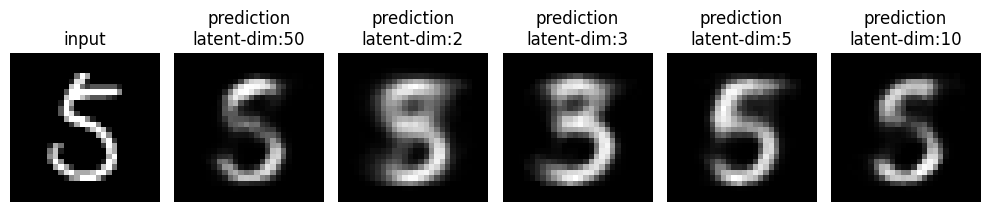

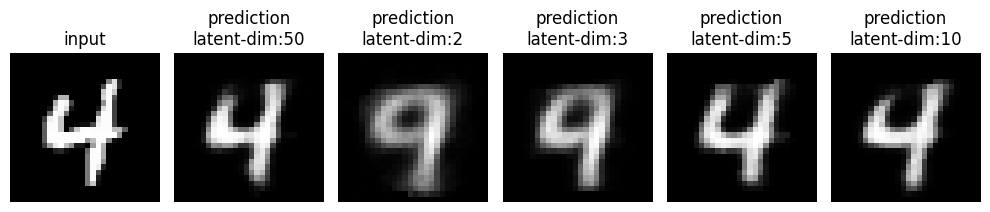

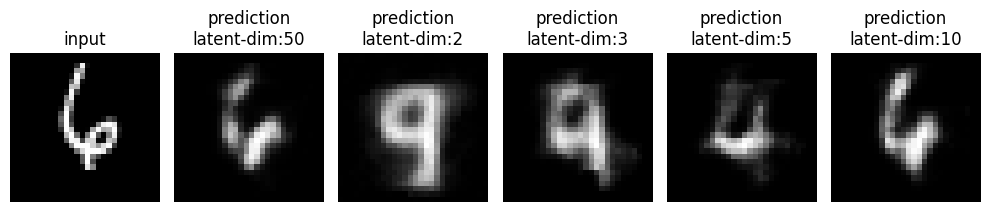

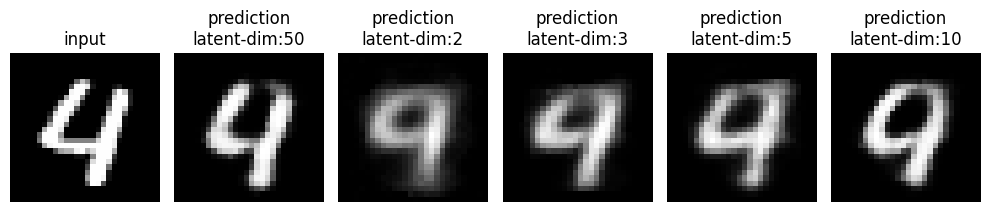

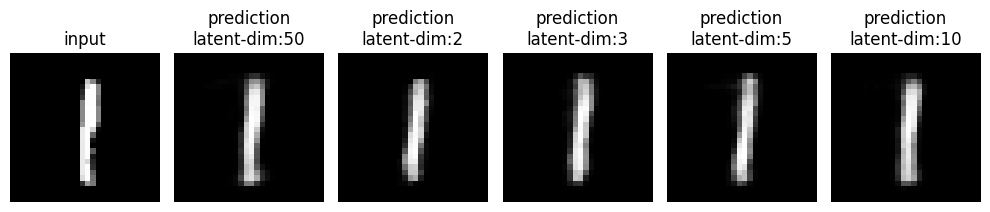

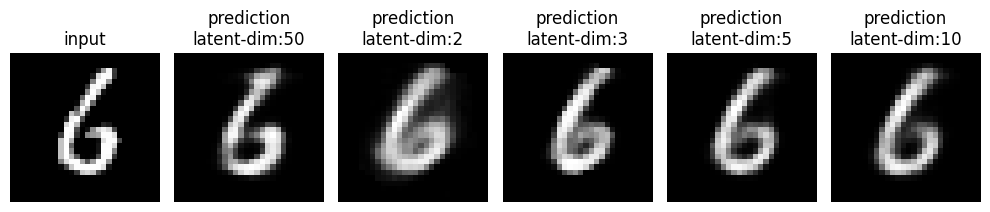

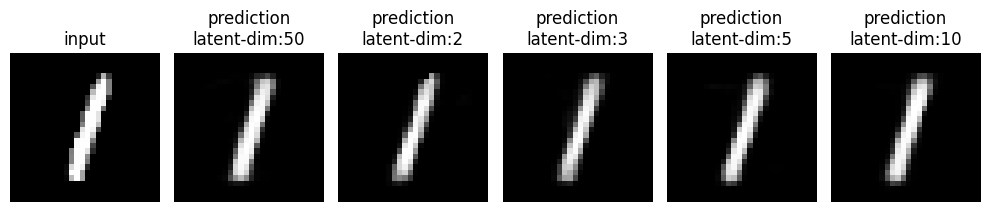

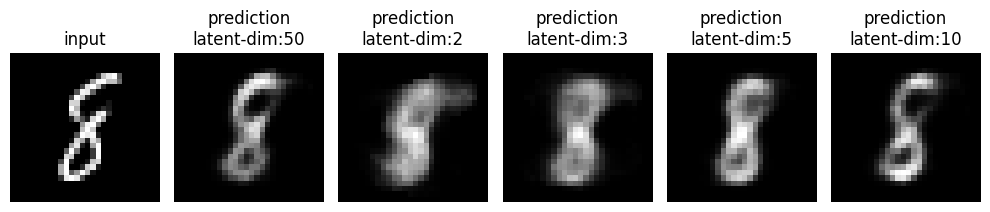

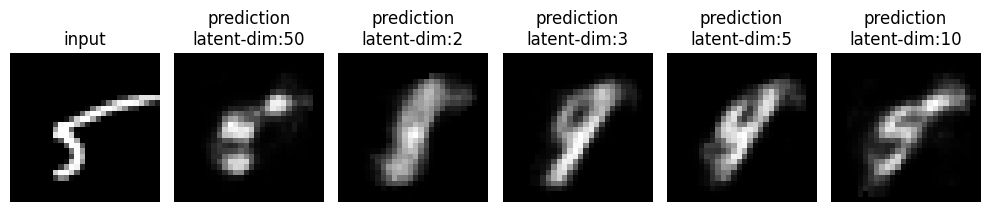

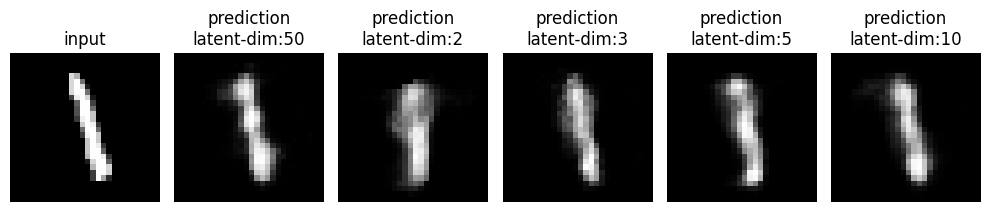

In [20]:
for _ in range(10):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    fig, ax = plt.subplots(1, len(aecs)+1, figsize=(10,4))
    ax = iter(ax.flat)
    show(im[0], ax=next(ax), title='input')
    for model in aecs:
        _im = model(im[None])[0]
        show(_im[0], ax=next(ax), title=f'prediction\nlatent-dim:{model.latend_dim}')
    plt.tight_layout()
    plt.show();